In [10]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

import plotly.graph_objects as go

import seaborn as sns

from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import mantel
import networkx as nx

In [2]:
env_data_dir = '../01_data/00_metadata/'
env_data_filename = 'metadata_chile_cont'

bio_data_dir = '../01_data/01_motus'
phylum_data_ = 'phylumDataFrame.tsv'
class_data_ = 'classDataFrame.tsv'
order_data_ = 'orderDataFrame.tsv'

In [3]:
metadata_df = pd.read_csv(os.path.join(env_data_dir, env_data_filename + '.tsv'), sep='\t', index_col=0)
phylum_df = pd.read_csv(os.path.join(bio_data_dir, phylum_data_), sep='\t', index_col=0)
class_df = pd.read_csv(os.path.join(bio_data_dir, class_data_), sep='\t', index_col=0)
order_df = pd.read_csv(os.path.join(bio_data_dir, order_data_), sep='\t', index_col=0)

# Sunagawa style

In [4]:

corr_matrix = metadata_df.corr(method='pearson')

mantel_results = []

for feature in metadata_df.columns:
    feature_dist = squareform(pdist(metadata_df[[feature]], metric='euclidean'))
    
    mantel_phylum = mantel(feature_dist, squareform(pdist(phylum_df, metric='euclidean')), method='pearson', permutations=9999)
    mantel_class = mantel(feature_dist, squareform(pdist(class_df, metric='euclidean')), method='pearson', permutations=9999)
    mantel_order = mantel(feature_dist, squareform(pdist(order_df, metric='euclidean')), method='pearson', permutations=9999)
    
    mantel_results.append({
        'feature': feature,
        'mantel_r_phylum': mantel_phylum[0],
        'p_value_phylum': mantel_phylum[1],
        'mantel_r_class': mantel_class[0],
        'p_value_class': mantel_class[1],
        'mantel_r_order': mantel_order[0],
        'p_value_order': mantel_order[1]
    })

mantel_df = pd.DataFrame(mantel_results)

print(mantel_df)

                 feature  mantel_r_phylum  p_value_phylum  mantel_r_class  \
0              Depth [m]         0.107919          0.0098        0.166869   
1       Temperature [ºC]         0.189878          0.0001        0.361927   
2         Salinity [PSU]         0.099643          0.0385        0.067453   
3        Density [kg/m3]         0.138156          0.0080        0.133281   
4          Oxygen [ml/l]         0.370674          0.0001        0.385907   
5             Oxygen [%]         0.413850          0.0001        0.453590   
6   Fluorescence [mg/m3]         0.205775          0.0004        0.145948   
7    Orthophosphate [uM]         0.354339          0.0001        0.459925   
8      Silicic-acid [uM]         0.276419          0.0001        0.311483   
9           Nitrite [uM]         0.161070          0.0022        0.100317   
10         Nitrates [uM]         0.365270          0.0001        0.452127   
11          Nitrate [uM]         0.383720          0.0001        0.450274   

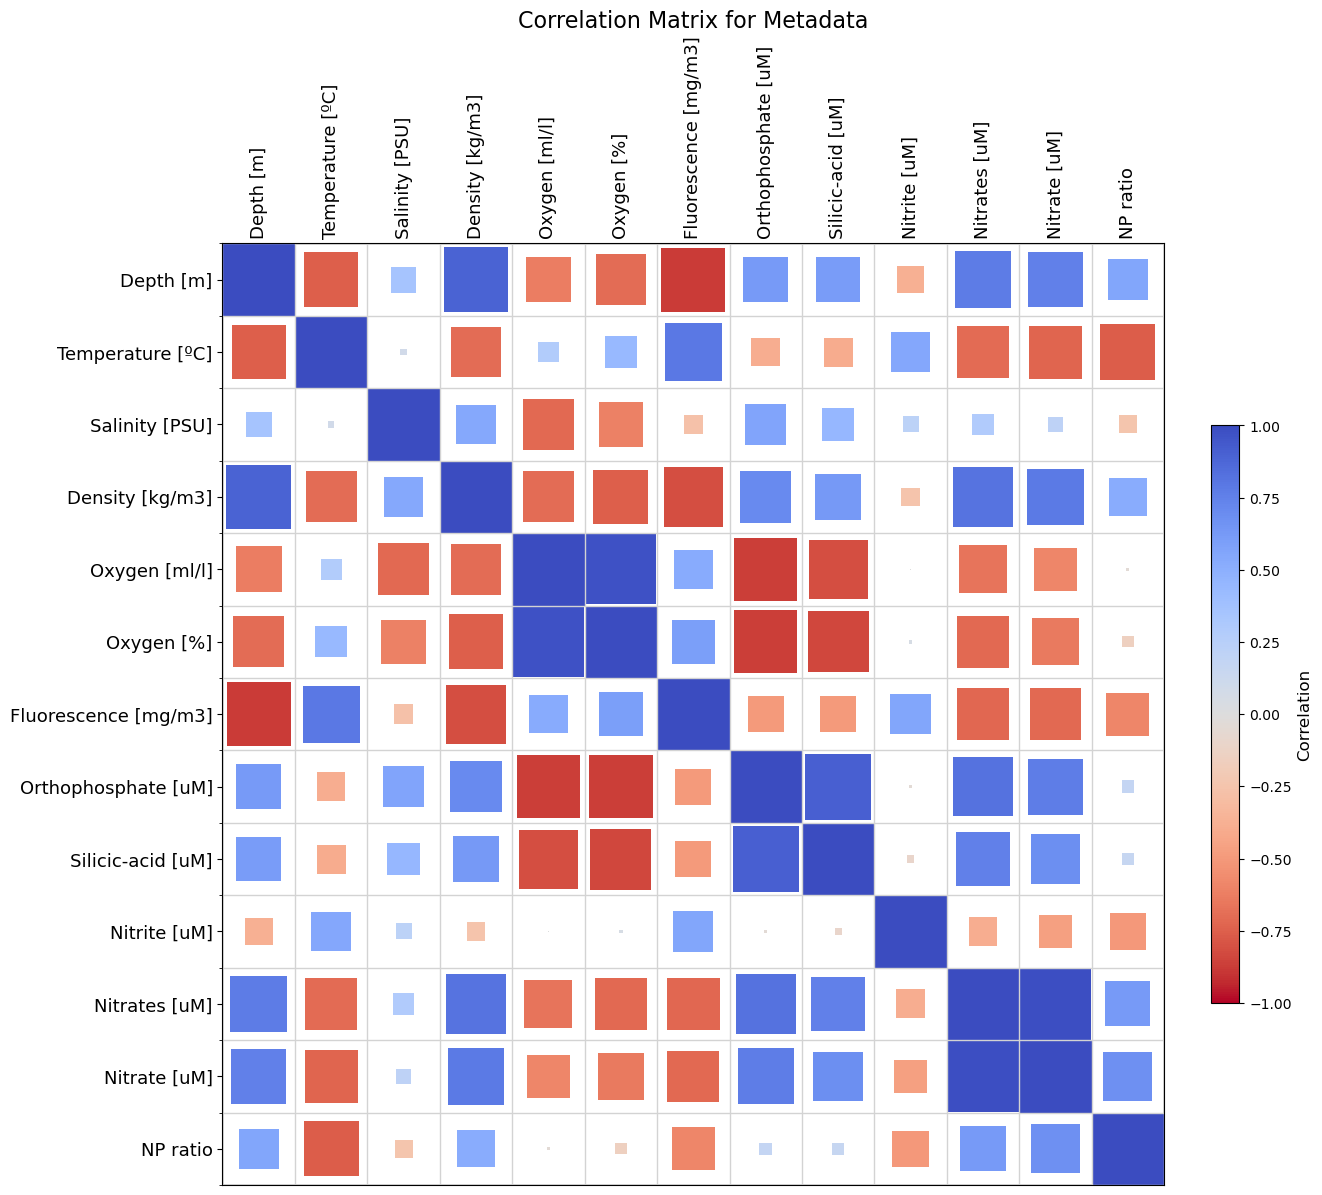

In [15]:
corr_df = metadata_df.corr(method='spearman')

output_dir = '../03_results/out_correlations'
output_file = 'metadata_correlation_matrix'
out_filename = os.path.join(output_dir, f'{output_file}.tsv')
corr_df.to_csv(out_filename, sep='\t')

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('white')
ax.imshow(np.ones_like(corr_df), cmap='gray_r', interpolation='nearest')

ax.set_xticks(np.arange(len(corr_df.columns)))
ax.set_yticks(np.arange(len(corr_df.index)))
ax.tick_params(axis='x', which='both', labelbottom=False, labeltop=True, bottom=False, top=True, length=0)
ax.set_yticklabels(corr_df.index, fontsize=13, color="black")
ax.set_xticklabels(corr_df.columns, fontsize=13, color="black", rotation=90)

ax.set_xticks(np.arange(len(corr_df.columns) + 1) - .5, minor=True)
ax.set_yticks(np.arange(len(corr_df.index) + 1) - .5, minor=True)
ax.grid(which="minor", color="lightgray", linestyle="-", linewidth=1)

rect = plt.Rectangle((-.5, -.5), len(corr_df.columns), len(corr_df.index), linewidth=2, edgecolor='lightgray', facecolor='none')
ax.add_patch(rect)

norm = plt.Normalize(-1, 1)
sm = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm_r')
for i in range(len(corr_df.columns)):
    for j in range(len(corr_df.index)):
        correlation = corr_df.iat[j, i]
        color = sm.to_rgba(correlation)
        size = abs(correlation) * 1
        rect = Rectangle(xy=(i - size / 2, j - size / 2), width=size, height=size, facecolor=color)
        ax.add_patch(rect)

cbar = plt.colorbar(sm, ax=ax, shrink=0.5, aspect=20, pad=0.04)
cbar.set_label('Correlation', fontsize=12)
plt.title('Correlation Matrix for Metadata', fontsize=16)

pdf_filename = os.path.join(output_dir, f'{output_file}.pdf')
plt.savefig(pdf_filename, bbox_inches='tight')

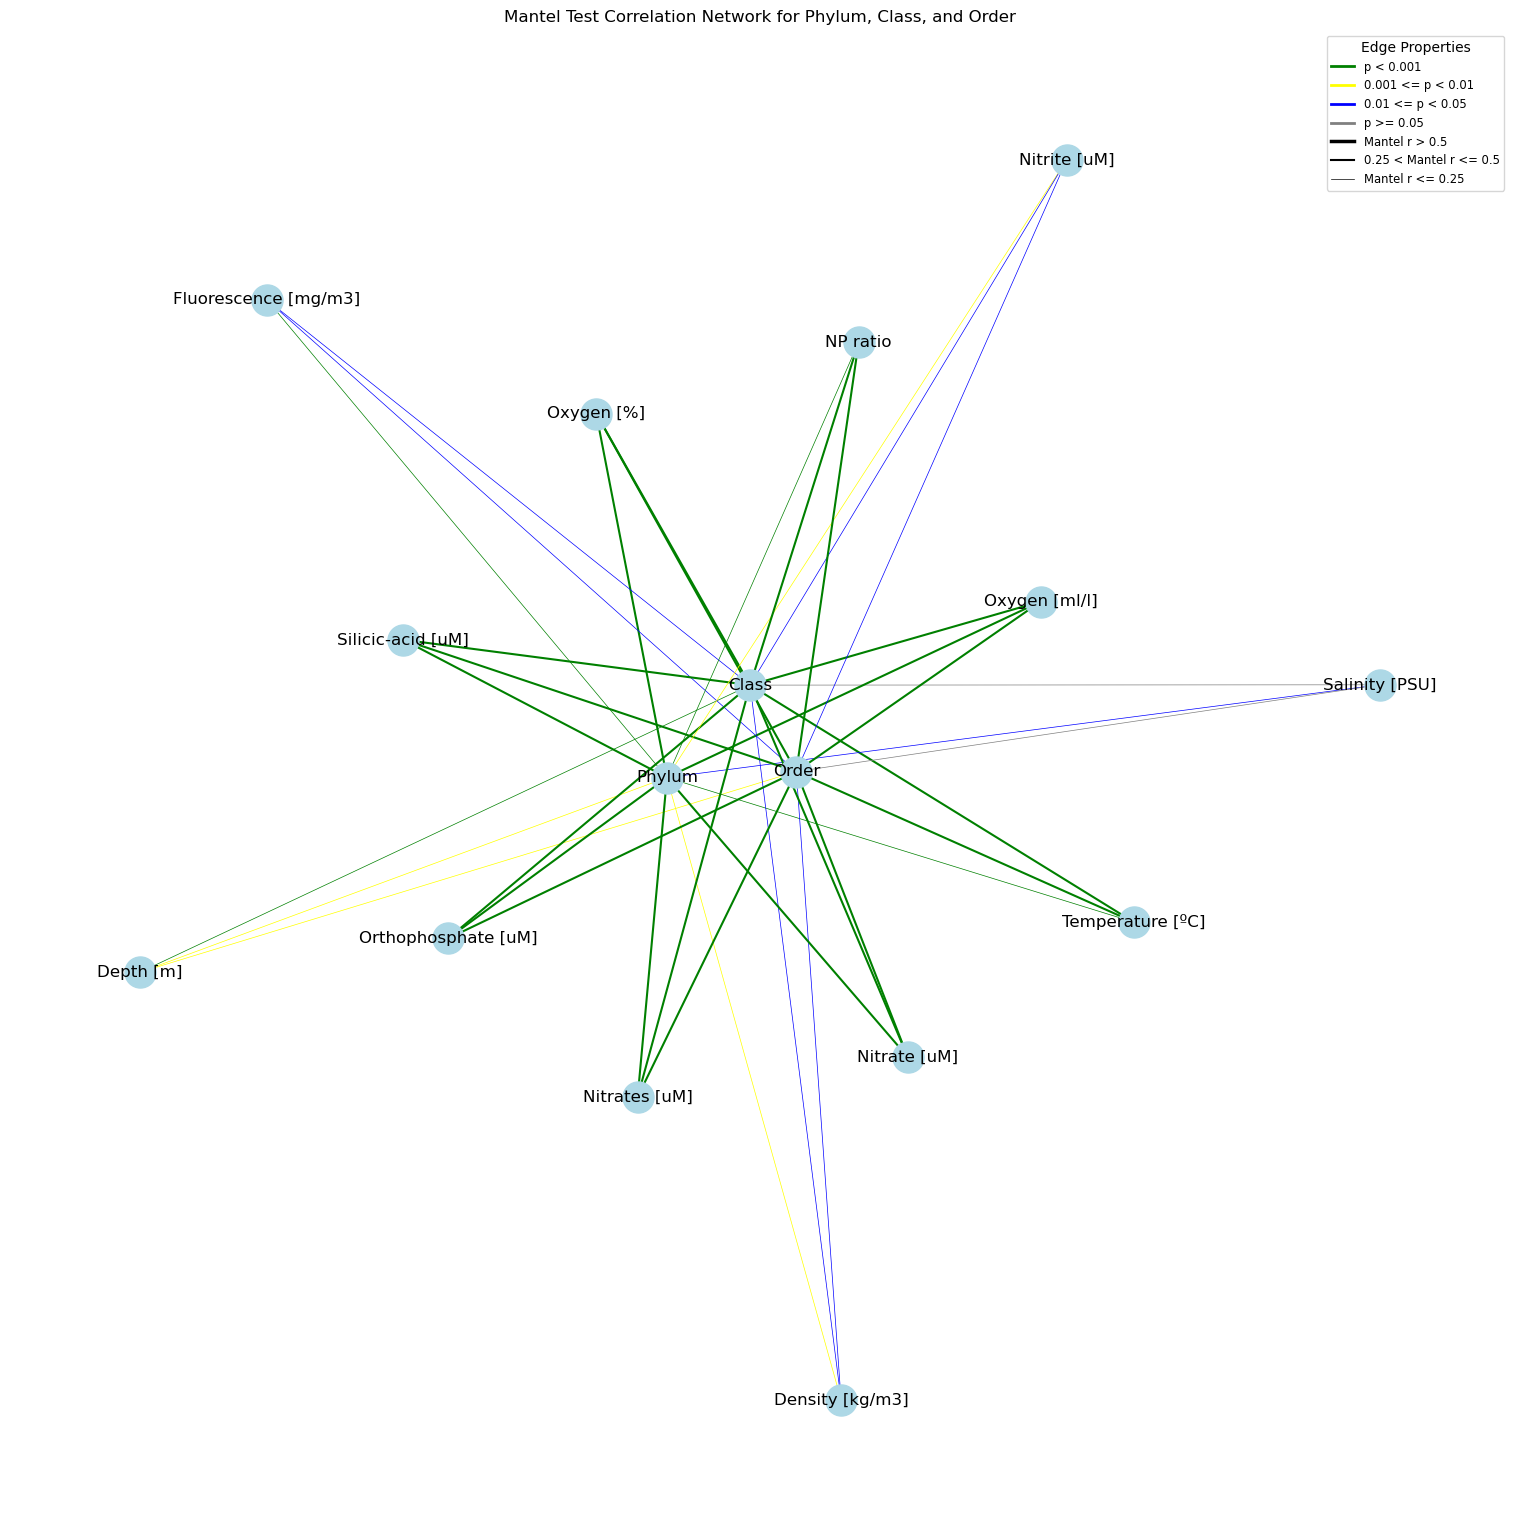

In [6]:
# Create a network graph
G = nx.Graph()

# Add nodes for features and taxa
for feature in mantel_df['feature']:
    G.add_node(feature, type='feature')

# Add nodes for taxonomic categories
G.add_node('Phylum', type='taxa')
G.add_node('Class', type='taxa')
G.add_node('Order', type='taxa')

# Add edges based on Mantel's r for Phylum
for idx, row in mantel_df.iterrows():
    r_value = row['mantel_r_phylum']
    p_value = row['p_value_phylum']
    # Determine edge thickness based on Mantel's r
    if r_value > 0.5:
        width = 2.5
    elif r_value > 0.25:
        width = 1.5
    else:
        width = 0.5
    
    # Determine edge color based on p-value
    if p_value < 0.001:
        color = 'green'
    elif p_value < 0.01:
        color = 'yellow'
    elif p_value < 0.05:
        color = 'blue'
    else:
        color = 'gray'
    
    G.add_edge(row['feature'], 'Phylum', weight=width, color=color)

# Add edges based on Mantel's r for Class
for idx, row in mantel_df.iterrows():
    r_value = row['mantel_r_class']
    p_value = row['p_value_class']
    # Determine edge thickness based on Mantel's r
    if r_value > 0.5:
        width = 2.5
    elif r_value > 0.25:
        width = 1.5
    else:
        width = 0.5
    
    # Determine edge color based on p-value
    if p_value < 0.001:
        color = 'green'
    elif p_value < 0.01:
        color = 'yellow'
    elif p_value < 0.05:
        color = 'blue'
    else:
        color = 'gray'
    
    G.add_edge(row['feature'], 'Class', weight=width, color=color)

# Add edges based on Mantel's r for Order
for idx, row in mantel_df.iterrows():
    r_value = row['mantel_r_order']
    p_value = row['p_value_order']
    # Determine edge thickness based on Mantel's r
    if r_value > 0.5:
        width = 2.5
    elif r_value > 0.25:
        width = 1.5
    else:
        width = 0.5
    
    # Determine edge color based on p-value
    if p_value < 0.001:
        color = 'green'
    elif p_value < 0.01:
        color = 'yellow'
    elif p_value < 0.05:
        color = 'blue'
    else:
        color = 'gray'
    
    G.add_edge(row['feature'], 'Order', weight=width, color=color)

# Extract edge attributes
edges = G.edges(data=True)
colors = [e[2]['color'] for e in edges]
weights = [e[2]['weight'] for e in edges]

plt.figure(figsize=(15, 15))

# Draw the network
pos = nx.spring_layout(G)
nx.draw(G, pos, edge_color=colors, width=weights, with_labels=True, node_color='lightblue', node_size=500)

# Add legend for edge colors
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='p < 0.001'),
    Line2D([0], [0], color='yellow', lw=2, label='0.001 <= p < 0.01'),
    Line2D([0], [0], color='blue', lw=2, label='0.01 <= p < 0.05'),
    Line2D([0], [0], color='gray', lw=2, label='p >= 0.05')
]

# Add legend for edge thickness
legend_elements += [
    Line2D([0], [0], color='black', lw=2.5, label='Mantel r > 0.5'),
    Line2D([0], [0], color='black', lw=1.5, label='0.25 < Mantel r <= 0.5'),
    Line2D([0], [0], color='black', lw=0.5, label='Mantel r <= 0.25')
]

plt.legend(handles=legend_elements, loc='best', fontsize='small', title="Edge Properties")

plt.title('Mantel Test Correlation Network for Phylum, Class, and Order')
plt.show()

In [17]:
out_dir_mantel = '../03_results/out_mantel'
out_file = 'mantel_results'
out_filename = os.path.join(out_dir_mantel,f'{out_file}.pdf')


# Create a network graph
G = nx.Graph()

# Define two sets of nodes for bipartite graph
left_nodes = ['Phylum', 'Class', 'Order']
right_nodes = list(mantel_df['feature'])

# Add nodes to the graph
for node in left_nodes:
    G.add_node(node, bipartite=0)  # Add left nodes

for node in right_nodes:
    G.add_node(node, bipartite=1)  # Add right nodes

# Add edges based on Mantel's r for Phylum
for idx, row in mantel_df.iterrows():
    r_value = row['mantel_r_phylum']
    p_value = row['p_value_phylum']
    # Determine edge thickness based on Mantel's r
    if r_value > 0.5:
        width = 2.5
    elif r_value > 0.25:
        width = 1.5
    else:
        width = 0.5
    
    # Determine edge color based on p-value
    if p_value < 0.001:
        color = 'green'
    elif p_value < 0.01:
        color = 'yellow'
    elif p_value < 0.05:
        color = 'blue'
    else:
        color = 'gray'
    
    G.add_edge(row['feature'], 'Phylum', weight=width, color=color)

# Add edges based on Mantel's r for Class
for idx, row in mantel_df.iterrows():
    r_value = row['mantel_r_class']
    p_value = row['p_value_class']
    # Determine edge thickness based on Mantel's r
    if r_value > 0.5:
        width = 2.5
    elif r_value > 0.25:
        width = 1.5
    else:
        width = 0.5
    
    # Determine edge color based on p-value
    if p_value < 0.001:
        color = 'green'
    elif p_value < 0.01:
        color = 'yellow'
    elif p_value < 0.05:
        color = 'blue'
    else:
        color = 'gray'
    
    G.add_edge(row['feature'], 'Class', weight=width, color=color)

# Add edges based on Mantel's r for Order
for idx, row in mantel_df.iterrows():
    r_value = row['mantel_r_order']
    p_value = row['p_value_order']
    # Determine edge thickness based on Mantel's r
    if r_value > 0.5:
        width = 2.5
    elif r_value > 0.25:
        width = 1.5
    else:
        width = 0.5
    
    # Determine edge color based on p-value
    if p_value < 0.001:
        color = 'green'
    elif p_value < 0.01:
        color = 'yellow'
    elif p_value < 0.05:
        color = 'blue'
    else:
        color = 'gray'
    
    G.add_edge(row['feature'], 'Order', weight=width, color=color)

# Extract edge attributes
edges = G.edges(data=True)
colors = [e[2]['color'] for e in edges]
weights = [e[2]['weight'] for e in edges]

# Position the nodes in a bipartite layout
pos = {}
pos.update((node, (0, i)) for i, node in enumerate(left_nodes))  # Left nodes at x=0
pos.update((node, (1, i)) for i, node in enumerate(right_nodes))  # Right nodes at x=1

# Increase the figure size
plt.figure(figsize=(10, 10))

# Draw the network
nx.draw(G, pos, edge_color=colors, width=weights, with_labels=True, node_color='lightblue', node_size=500)

# Add legend for edge colors
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='p < 0.001'),
    Line2D([0], [0], color='yellow', lw=2, label='0.001 <= p < 0.01'),
    Line2D([0], [0], color='blue', lw=2, label='0.01 <= p < 0.05'),
    Line2D([0], [0], color='gray', lw=2, label='p >= 0.05')
]

# Add legend for edge thickness
legend_elements += [
    Line2D([0], [0], color='black', lw=2.5, label='Mantel r > 0.5'),
    Line2D([0], [0], color='black', lw=1.5, label='0.25 < Mantel r <= 0.5'),
    Line2D([0], [0], color='black', lw=0.5, label='Mantel r <= 0.25')
]

plt.legend(handles=legend_elements, loc='best', fontsize='small', title="Edge Properties")

plt.title('Mantel Test Correlation Network for Phylum, Class, and Order')

# Save the figure to the specified file
plt.savefig(out_filename, bbox_inches='tight')

plt.show()

## PLOTLY VARIANT

In [8]:
# Create a network graph
G = nx.Graph()

# Add nodes for features and taxa
for feature in mantel_df['feature']:
    G.add_node(feature, type='feature')

# Add nodes for taxonomic categories
G.add_node('Phylum', type='taxa')
G.add_node('Class', type='taxa')
G.add_node('Order', type='taxa')

# Add edges based on Mantel's r for Phylum, Class, and Order
for level, taxa in [('mantel_r_phylum', 'Phylum'), ('mantel_r_class', 'Class'), ('mantel_r_order', 'Order')]:
    for idx, row in mantel_df.iterrows():
        r_value = row[level]
        p_value = row['p_value_' + taxa.lower()]
        
        # Determine edge thickness based on Mantel's r
        if r_value > 0.5:
            width = 2.5
        elif r_value > 0.25:
            width = 1.5
        else:
            width = 0.5
        
        # Determine edge color based on p-value
        if p_value < 0.001:
            color = 'green'
        elif p_value < 0.01:
            color = 'yellow'
        elif p_value < 0.05:
            color = 'blue'
        else:
            color = 'gray'
        
        G.add_edge(row['feature'], taxa, weight=width, color=color)

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Create a trace for each edge
edge_traces = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace = go.Scatter(
        x=[x0, x1, None], y=[y0, y1, None],
        line=dict(width=edge[2]['weight'], color=edge[2]['color']),
        hoverinfo='none',
        mode='lines'
    )
    edge_traces.append(edge_trace)

# Extract node attributes for Plotly
node_x = []
node_y = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

# Create the node traces
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='top center',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        color='lightblue',
        size=10,
        line_width=2
    )
)

# Create the figure
fig = go.Figure(data=edge_traces + [node_trace],
                layout=go.Layout(
                    title='Mantel Test Correlation Network for Phylum, Class, and Order',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0,l=0,r=0,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

# Add the legend manually
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='p < 0.001'),
    Line2D([0], [0], color='yellow', lw=2, label='0.001 <= p < 0.01'),
    Line2D([0], [0], color='blue', lw=2, label='0.01 <= p < 0.05'),
    Line2D([0], [0], color='gray', lw=2, label='p >= 0.05'),
    Line2D([0], [0], color='black', lw=2.5, label='Mantel r > 0.5'),
    Line2D([0], [0], color='black', lw=1.5, label='0.25 < Mantel r <= 0.5'),
    Line2D([0], [0], color='black', lw=0.5, label='Mantel r <= 0.25')
]

for i, legend_item in enumerate(legend_elements):
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers+lines',
        line=dict(color=legend_item.get_color(), width=legend_item.get_linewidth()),
        marker=dict(size=10, color=legend_item.get_color()),
        legendgroup=str(i),
        name=legend_item.get_label()
    ))

fig.show()

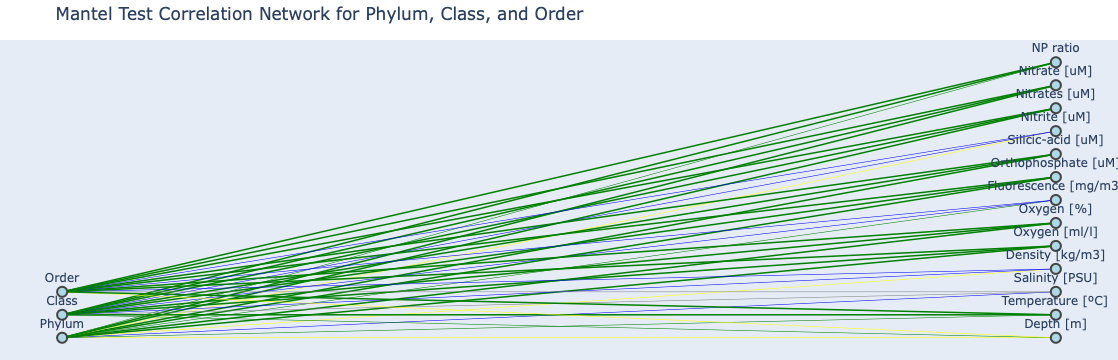

In [9]:
# Create a network graph
G = nx.Graph()

# Define two sets of nodes for bipartite graph
left_nodes = ['Phylum', 'Class', 'Order']
right_nodes = list(mantel_df['feature'])

# Add nodes to the graph
for node in left_nodes:
    G.add_node(node, bipartite=0)  # Add left nodes

for node in right_nodes:
    G.add_node(node, bipartite=1)  # Add right nodes

# Add edges based on Mantel's r for Phylum, Class, and Order
for level, taxa in [('mantel_r_phylum', 'Phylum'), ('mantel_r_class', 'Class'), ('mantel_r_order', 'Order')]:
    for idx, row in mantel_df.iterrows():
        r_value = row[level]
        p_value = row['p_value_' + taxa.lower()]
        
        # Determine edge thickness based on Mantel's r
        if r_value > 0.5:
            width = 2.5
        elif r_value > 0.25:
            width = 1.5
        else:
            width = 0.5
        
        # Determine edge color based on p-value
        if p_value < 0.001:
            color = 'green'
        elif p_value < 0.01:
            color = 'yellow'
        elif p_value < 0.05:
            color = 'blue'
        else:
            color = 'gray'
        
        G.add_edge(row['feature'], taxa, weight=width, color=color)

# Position the nodes in a bipartite layout
pos = {}
pos.update((node, (0, i)) for i, node in enumerate(left_nodes))  # Left nodes at x=0
pos.update((node, (1, i)) for i, node in enumerate(right_nodes))  # Right nodes at x=1

# Create a trace for each edge
edge_traces = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace = go.Scatter(
        x=[x0, x1, None], y=[y0, y1, None],
        line=dict(width=edge[2]['weight'], color=edge[2]['color']),
        hoverinfo='none',
        mode='lines'
    )
    edge_traces.append(edge_trace)

# Extract node attributes for Plotly
node_x = []
node_y = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)  # This will be the label of the node

# Create the node traces
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='top center',  # Position the labels above the nodes
    hoverinfo='text',
    marker=dict(
        showscale=False,
        color='lightblue',
        size=10,
        line_width=2
    )
)

# Create the figure
fig = go.Figure(data=edge_traces + [node_trace],
                layout=go.Layout(
                    title='Mantel Test Correlation Network for Phylum, Class, and Order',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0,l=0,r=0,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

# Add the legend manually
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='p < 0.001'),
    Line2D([0], [0], color='yellow', lw=2, label='0.001 <= p < 0.01'),
    Line2D([0], [0], color='blue', lw=2, label='0.01 <= p < 0.05'),
    Line2D([0], [0], color='gray', lw=2, label='p >= 0.05'),
    Line2D([0], [0], color='black', lw=2.5, label='Mantel r > 0.5'),
    Line2D([0], [0], color='black', lw=1.5, label='0.25 < Mantel r <= 0.5'),
    Line2D([0], [0], color='black', lw=0.5, label='Mantel r <= 0.25')
]

for i, legend_item in enumerate(legend_elements):
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers+lines',
        line=dict(color=legend_item.get_color(), width=legend_item.get_linewidth()),
        marker=dict(size=10, color=legend_item.get_color()),
        legendgroup=str(i),
        name=legend_item.get_label()
    ))

fig.show()